# Classifying `Direction` in the `Weekly` dataset

## Preparing the Data

### Import

In [1]:
import pandas as pd

weekly = pd.read_csv('../../datasets/Weekly.csv', index_col=0)
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
2,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
3,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
4,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
5,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [2]:
weekly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089 entries, 1 to 1089
Data columns (total 9 columns):
Year         1089 non-null int64
Lag1         1089 non-null float64
Lag2         1089 non-null float64
Lag3         1089 non-null float64
Lag4         1089 non-null float64
Lag5         1089 non-null float64
Volume       1089 non-null float64
Today        1089 non-null float64
Direction    1089 non-null object
dtypes: float64(7), int64(1), object(1)
memory usage: 85.1+ KB


### Preprocessing

#### Converting qualitative variables to quantitative

Don't see any null values but let's check

In [3]:
weekly.isna().sum().sum()

0

`Direction` is a qualitative variable encoded as a string; let's encode it numerically 

In [4]:
import sklearn.preprocessing as skl_preprocessing

# create and fit label encoder
direction_le = skl_preprocessing.LabelEncoder()
direction_le.fit(weekly.Direction)

# replace string encoding with numeric
weekly['Direction_num'] = direction_le.transform(weekly.Direction)
weekly.Direction_num.head()

1    0
2    0
3    1
4    1
5    1
Name: Direction_num, dtype: int64

In [5]:
direction_le.classes_

array(['Down', 'Up'], dtype=object)

In [6]:
direction_le.transform(direction_le.classes_)

array([0, 1])

So the encoding is {`Down`:0, `Up`:1}

## (a) Numerical and graphical summaries

Here's a description of the dataset from the `R` documentation

```
Weekly S&P Stock Market Data

Description

Weekly percentage returns for the S&P 500 stock index between 1990 and 2010.

Usage

Weekly
Format

A data frame with 1089 observations on the following 9 variables.

Year
The year that the observation was recorded

Lag1
Percentage return for previous week

Lag2
Percentage return for 2 weeks previous

Lag3
Percentage return for 3 weeks previous

Lag4
Percentage return for 4 weeks previous

Lag5
Percentage return for 5 weeks previous

Volume
Volume of shares traded (average number of daily shares traded in billions)

Today
Percentage return for this week

Direction
A factor with levels Down and Up indicating whether the market had a positive or negative return on a given week

Source

Raw values of the S&P 500 were obtained from Yahoo Finance and then converted to percentages and lagged.
```

Let's look at summary statistics

In [7]:
weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_num
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899,0.555556
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927,0.497132
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000,0.000000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000,0.000000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000,1.000000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000,1.000000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000,1.000000


- All the variables ranges look good (e.g. no negative values for volume)

- The `Lag` variables and `Today` all have very similar summary statistics, as expected.

- Of particular interest is `Direction_num`, which has a mean of $\approx 0.56$ and a standard deviation of $\approx 0.50$! 
That's what we'll be trying to predict later in the exercise, which will be interesting.

Let's look at distributions

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')
sns.set_style('white')

import warnings  
warnings.filterwarnings('ignore')

import numpy as np

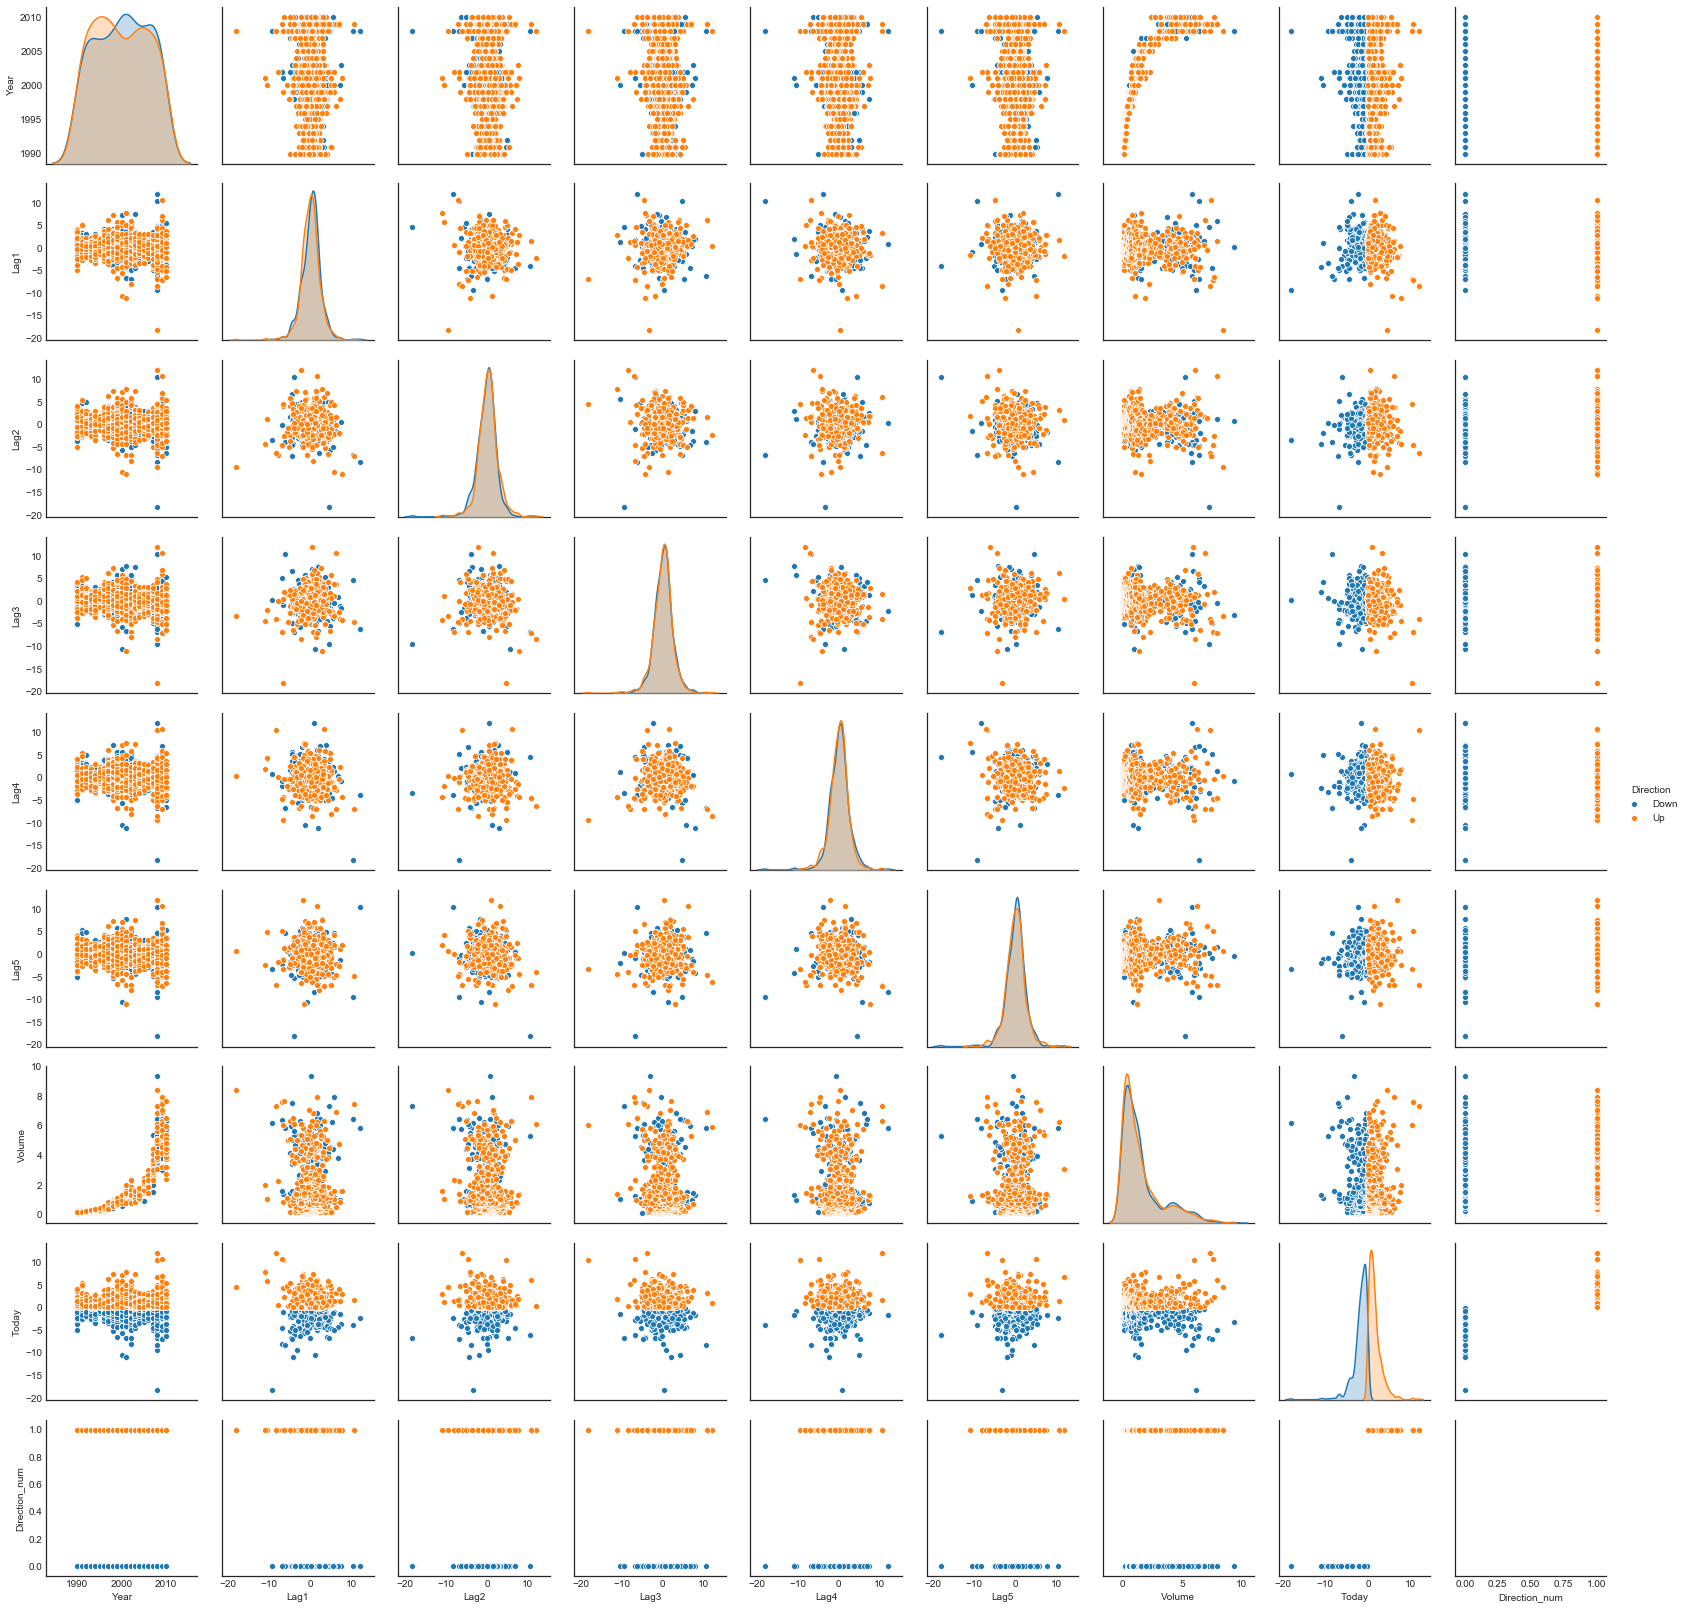

In [10]:
sns.pairplot(weekly, hue='Direction')

### The return variables are concentrated

The return variables  (i.e. `Lag` and `Today` variables) are "tight" instead of spread out, i.e. fairly concentrated about their mean.

Here are the deviations of all variables as percentages of the magnitude of their ranges

In [11]:
weekly_num = weekly.drop('Direction', axis=1)
round(100 * (weekly_num.std() / (weekly_num.max() - weekly_num.min())), 2)

Year             30.17
Lag1              7.80
Lag2              7.80
Lag3              7.81
Lag4              7.81
Lag5              7.81
Volume           18.25
Today             7.80
Direction_num    49.71
dtype: float64

### Return variables are nearly uncorrelated

In the pairplot there is a visible lack of pairwise sample correlation among the return variables.

In [12]:
weekly.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_num
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460,-0.022200
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032,-0.050004
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167,0.072696
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244,-0.022913
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826,-0.020549
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013,-0.018168
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078,-0.017995
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000,0.720025
Direction_num,-0.022200,-0.050004,0.072696,-0.022913,-0.020549,-0.018168,-0.017995,0.720025,1.000000


Indeed the magnitudes of the sample correlations for these pairs are quite small.

### `Volume` correlates with `Year`

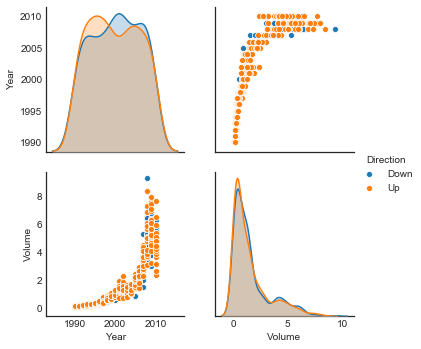

In [13]:
sns.pairplot(weekly, vars=['Year', 'Volume'], hue='Direction')

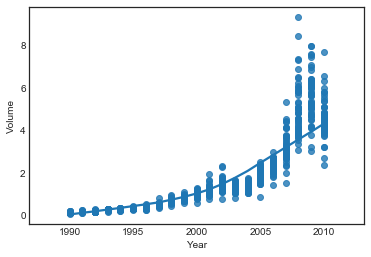

In [14]:
sns.regplot(weekly.Year, weekly.Volume, lowess=True)

## (b) Logistic Regression Classification of `Direction` using `Lag` and `Volume` predictors

In [15]:
import statsmodels.api as sm

# predictor labels
predictors = ['Lag' + str(i) for i in range(1, 6)]
predictors += ['Volume']

# fit and summarize model

sm_logit_model_full = sm.Logit(weekly.Direction_num, sm.add_constant(weekly[predictors]))
sm_logit_model_full.fit().summary()

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Direction_num   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Mon, 26 Nov 2018   Pseudo R-squ.:                0.006580
Time:                        17:27:33   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
                                        LLR p-value:                    0.1313
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

Only the intercept and `Lag2` and appear to be statistically significant

## (c) Confusion Matrix

In [16]:
import sklearn.linear_model as skl_linear_model

# fit model
skl_logit_model_full = skl_linear_model.LogisticRegression()
X, Y = sm.add_constant(weekly[predictors]).values, weekly.Direction_num.values
skl_logit_model_full.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
# check paramaters are close in the two models
abs(skl_logit_model_full.coef_ - sm_logit_model_full.fit().params.values)

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


array([[1.33953314e-01, 6.15092984e-05, 3.94405141e-06, 4.06643634e-05,
        5.96004698e-05, 3.92562567e-05, 3.22507048e-04]])

In [18]:
import sklearn.metrics as skl_metrics

# confusion matrix
confusion_array = skl_metrics.confusion_matrix(Y, skl_logit_model_full.predict(X))
confusion_array

array([[ 54, 430],
       [ 47, 558]])

In [19]:
# confusion data frame
col_index = pd.MultiIndex.from_product([['Pred'], [0, 1]])
row_index = pd.MultiIndex.from_product([['Actual'], [0, 1]])
confusion_df = pd.DataFrame(confusion_array, columns=col_index, index=row_index)
confusion_df.loc[: ,('Pred','Total')] = confusion_df.Pred[0] + confusion_df.Pred[1]
confusion_df.loc[('Actual','Total'), :] = (confusion_df.loc[('Actual',0), :] + 
                                        confusion_df.loc[('Actual',1), :])
confusion_df.astype('int32')

Pred           
                0    1 Total
Actual 0       54  430   484
       1       47  558   605
       Total  101  988  1089

### Performance rates of interest from the confusion matrix

Recall that for a binary classifier the confusion matrix shows

$$
\begin{matrix}
\text{Pred} \\
\text{Actual}
\begin{pmatrix}
TN & FP & ActNeg\\
FN & TP & ActPos\\
PredNeg & PredPos & n
\end{pmatrix}
\end{matrix}
$$

where

$$
\begin{align}
TP & = \text{True Positives}\\
FP & = \text{False Positives}\\
FN & = \text{False Negatives}\\
TN & = \text{True Negatives}\\
ActNeg &= \text{Total Actual Negatives} = TN + FP\\
ActPos &= \text{Total Actual Positives} = FN + TP\\
PredNeg &= \text{Total Predicted Negatives} = TN + FN\\
PredPos &= \text{Total Predicted Positives} = FP + TP\\
\end{align}
$$

Also recall the following rates of interest

- The ***accuracy*** of the classifier is the proportion of correctly classified observations 

$$ \frac{TP + TN}{n} $$

i.e., "How often is the model right?"

- The ***misclassification rate*** (or ***error rate***) is the proportion of incorrectly classified observations 

$$ \frac{FP + FN}{n}$$

i.e., "How often is the model wrong?"

- The ***null error rate*** is the proportion of the majority class

$$ \frac{\max\{ActNeg, ActPos\}}{n} $$

i.e. "How often would we be wrong if we always predicted the majority class" 

- The ***true positive rate*** (or ***sensitivity*** or ***recall***) is the ratio of true positives to actual positives

$$ \frac{TP}{ActPos} $$

, "How often is the model right for actual positives ($Y=1$)?"

- The ***false positive rate*** is the ratio of false positives to actual negatives

$$ \frac{FP}{ActNeg}  = $$

i.e., "How often is the model wrong for actual positives?"

- The ***true negative rate*** or ***specificity*** is the ratio of true negatives to actual negatives

$$ \frac{TN}{ActNeg} $$

i.e., "How often is the model right for actual negatives ($Y=0$)?"

- The ***false negative rate*** is the ratio of true negatives to actual negatives

$$ \frac{FN}{ActNeg} $$

i.e., "How often is the model wrong for actual negatives ($Y=0$)?"

- The ***precision*** is the ratio of true positives to predicted positives

$$ \frac{TP}{PredPos} $$

i.e., "How often are the models' positive predictions right?"

- The ***prevalence*** is the ratio of actual positives to total observations

$$ \frac{FN + TP}{n} $$

i.e., "How often do actual positives occur in the sample?"



### Analyzing model performance rates

In [20]:
# necessary variables
n = confusion_df.loc[('Actual', 'Total'), ('Pred', 'Total')]
TN = confusion_df.loc[('Actual', 0), ('Pred', 0)]
FP = confusion_df.loc[('Actual', 0), ('Pred', 1)]
FN = confusion_df.loc[('Actual', 1), ('Pred', 0)]
TP = confusion_df.loc[('Actual', 1), ('Pred', 1)]

# compute rates
rates = {}
rates['accuracy'] = (TP + TN) / n
rates['error rate'] = (FP + FN) / n
rates['null error'] = max(FN + TP, FP + TN) / n
rates['TP rate'] = TP / (FN + TP)
rates['FP rate'] = FP / (FN + TP)
rates['TN rate'] = TN / (FP + TN)
rates['FN rate'] = FN / (FP + TN)
rates['precision'] = TP / (FP + TP)
rates['prevalence'] = (FN + TP) / n


# store results
model_perf_rates_df = pd.DataFrame(rates, index=[0])
model_perf_rates_df

,accuracy,error rate,null error,TP rate,FP rate,TN rate,FN rate,precision,prevalence
0,0.561983,0.438017,0.555556,0.922314,0.710744,0.11157,0.097107,0.564777,0.555556


#### Observations

- The accuracy is $\approx 56\%$ so the model is right a bit more than half the time

- The error rate is $\approx 44\%$ so the model is wrong a bit less than half the time

- The "null error rate" is the error rate of the "null classifier" which always predicts the majority class, which in this case is $\approx 56\%$. Thus our model is about as accurate as the null classifier.

- The true positive and false positive rates are relatively high. The true negative and false negative rates are relatively low. This makes sense -- inspection of the confusion matrix shows that the model predicts positives almost an order of magnitude more often

- The precision is $\approx 56\%$ so the model correctly predicts positives a little more than half the time

- The prevalence is also $\approx 56\%$ so positives occur in the sample a little more than half the time

We'll package this functionality for later use:

In [21]:
def confusion_results(X, y, skl_model_fit):
    # get confusion array
    confusion_array = skl_metrics.confusion_matrix(y, skl_model_fit.predict(X))

    # necessary variables
    n = np.sum(confusion_array)
    TN = confusion_array[0, 0]
    FP = confusion_array[0, 1]
    FN = confusion_array[1, 0]
    TP = confusion_array[1, 1]

    # compute rates
    rates = {}
    rates['accuracy'] = (TP + TN) / n
    rates['error rate'] = (FP + FN) / n
    rates['null error'] = max(FN + TP, FP + TN) / n
    rates['TP rate'] = TP / (FN + TP)
    rates['FP rate'] = FP / (FN + TP)
    rates['TN rate'] = TN / (FP + TN)
    rates['FN rate'] = FN / (FP + TN)
    rates['precision'] = TP / (FP + TP)
    rates['prevalence'] = (FN + TP) / n


    # return results
    return pd.DataFrame(rates, index=[0])

In [22]:
confusion_results(X, Y, skl_logit_model_full.fit(X, Y))

,accuracy,error rate,null error,TP rate,FP rate,TN rate,FN rate,precision,prevalence
0,0.561983,0.438017,0.555556,0.922314,0.710744,0.11157,0.097107,0.564777,0.555556


## (d) Logistic Regression Classification of `Direction` using `Lag2` predictor

In this section we do some feature selection. Since in (b) we found that only `Lag2` was a significant feature, we'll eliminate the others. Further, we'll train on the years 1990 to 2008 and test on 2009 to 2010

In [42]:
# train/test split
weekly_test, weekly_train = weekly[weekly['Year'] <= 2008], weekly[weekly['Year'] > 2008]
X_train, y_train = sm.add_constant(weekly_train['Lag2']), weekly_train['Direction_num']
X_test, y_test = sm.add_constant(weekly_test['Lag2']), weekly_test['Direction_num']

# fit new model
skl_logit_model_lag2 = skl_linear_model.LogisticRegression()

In [24]:
# confusion matrix
confusion_results(X_test, y_test, skl_logit_model_lag2.fit(X_train, y_train))

,accuracy,error rate,null error,TP rate,FP rate,TN rate,FN rate,precision,prevalence
0,0.550254,0.449746,0.552284,0.963235,0.777574,0.040816,0.045351,0.553326,0.552284


The accuracy is actually slightly worse than the full model

## (e)  Other classification models of `Direction` using `Lag2` predictor

### LDA

In [41]:
import sklearn.discriminant_analysis as skl_discriminant_analysis

skl_LDA_model_lag2 = skl_discriminant_analysis.LinearDiscriminantAnalysis()

In [26]:
# confusion matrix
confusion_results(X_test, y_test, skl_LDA_model_lag2.fit(X_train, y_train))

,accuracy,error rate,null error,TP rate,FP rate,TN rate,FN rate,precision,prevalence
0,0.550254,0.449746,0.552284,0.965074,0.779412,0.038549,0.043084,0.553214,0.552284


In [27]:
# accuracy
skl_metrics.accuracy_score(y_test, skl_LDA_model_lag2.predict(X_test))

0.550253807106599

Nearly identical to `skl_logit_model_lag2`!

### QDA

In [40]:
skl_QDA_model_lag2 = skl_discriminant_analysis.QuadraticDiscriminantAnalysis()

In [29]:
# confusion matrix
confusion_results(X_test, y_test, skl_QDA_model_lag2.fit(X_train, y_train))

,accuracy,error rate,null error,TP rate,FP rate,TN rate,FN rate,precision,prevalence
0,0.447716,0.552284,0.552284,0.0,0.0,1.0,1.23356,NaN,0.552284


Worse accuracy than Logistic Regression and LDA

### KNN

In [39]:
import sklearn.neighbors as skl_neighbors

skl_KNN_model_lag2 = skl_neighbors.KNeighborsClassifier(n_neighbors=1)

In [43]:
# confusion matrix
confusion_results(X_test, y_test, skl_KNN_model_lag2.fit(X_train, y_train))

,accuracy,error rate,null error,TP rate,FP rate,TN rate,FN rate,precision,prevalence
0,0.518782,0.481218,0.552284,0.626838,0.498162,0.385488,0.460317,0.55719,0.552284


### Comparing results

For neatness and ease of comparison, we'll package all these results

In [44]:
def confusion_comparison(X, y, models):
    df = pd.concat([confusion_results(X, y, models[model_name]) 
                      for model_name in models])
    df['Model'] = list(models.keys())
    return df.set_index('Model')

In [45]:
models = {'Logit': skl_logit_model_lag2, 'LDA': skl_LDA_model_lag2, 
          'QDA': skl_QDA_model_lag2, 'KNN': skl_KNN_model_lag2}

In [46]:
for model_name in models:
    models[model_name] = models[model_name].fit(X_train, y_train)

conf_comp_df = confusion_comparison(X_test, y_test, models)
conf_comp_df

,accuracy,error rate,null error,TP rate,FP rate,TN rate,FN rate,precision,prevalence
Model,,,,,,,,,
Logit,0.550254,0.449746,0.552284,0.963235,0.777574,0.040816,0.045351,0.553326,0.552284
LDA,0.550254,0.449746,0.552284,0.965074,0.779412,0.038549,0.043084,0.553214,0.552284
QDA,0.447716,0.552284,0.552284,0.000000,0.000000,1.000000,1.233560,NaN,0.552284
KNN,0.518782,0.481218,0.552284,0.626838,0.498162,0.385488,0.460317,0.557190,0.552284


## (h) Which method has the best results?

As measured by accuracy, Logit and LDA models are tied, with KNN not too far behind and QDA a more distant third.

With respect to other confusion metrics, Logit and LDA are nearly identical

## (i) Feature and Model Selection

In this section, we'll experiment to try to find improved performance on the test data. We'll try:

- Different subsets of the predictors
- Interactions among the predictors
- Transformations of the predictors
- Different values of $K$ for KNN

### Get all predictor interactions

In [95]:
from itertools import combinations

# all pairs of columns in weekly except year and direction
df = weekly.drop(['Year', 'Direction', 'Direction_num'], axis=1)
col_pairs = combinations(df.columns, 2)

# assemble interactions in dataframe
interaction_df = pd.DataFrame({col1 + ':' + col2: weekly[col1]*weekly[col2] 
                               for (col1, col2) in col_pairs})

# concat data frames
dir_df = weekly[['Direction', 'Direction_num']]
weekly_interact = pd.concat([weekly.drop(['Direction', 'Direction_num'], axis=1),
                             interaction_df, dir_df], axis=1)
weekly_interact.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Lag1:Lag2,Lag1:Lag3,...,Lag3:Volume,Lag3:Today,Lag4:Lag5,Lag4:Volume,Lag4:Today,Lag5:Volume,Lag5:Today,Volume:Today,Direction,Direction_num
1,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,1.282752,-3.211776,...,-0.609986,1.062720,0.797836,-0.035490,0.061830,-0.539936,0.940680,-0.041844,Down,0
2,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,-0.220320,-0.424440,...,0.233558,-4.049472,0.901344,-0.584787,10.139136,-0.034023,0.589904,-0.382727,Down,0
3,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,0.695520,-2.102016,...,0.130427,2.867424,-6.187392,0.251265,5.524008,-0.629120,-13.831104,0.561669,Up,1
4,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,-9.052064,-0.948780,...,-0.043640,-0.192240,1.282752,0.131890,0.580992,0.254082,1.119264,0.115081,Up,1
5,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,2.501968,-1.834112,...,-0.396003,-3.034528,-0.220320,-0.041507,-0.318060,0.125442,0.961248,0.181092,Up,1


### Choose some transformations



In [50]:
# list of transformations

from numpy import sqrt, sin, log, exp, power

# power functions with odd exponent to preserve sign of inputs
def power_3(array):
    return np.power(array, 3)

def power_5(array):
    return np.power(array, 3)

def power_7(array):
    return np.power(array, 4)

# transformations are functions with domain all real numbers
transforms = [power_3, power_5, power_7, sin, exp]
transforms

[<function __main__.power_3(array)>,
 <function __main__.power_5(array)>,
 <function __main__.power_7(array)>,
 <ufunc 'sin'>,
 <ufunc 'exp'>]

### Random data tweak

We'll write a simple function which returns a dataset which has

- as predictors a random subset of the predictors and interactions of the original dataset (i.e. a random subset of the columns of `weekly_interact`)
- a random subset of its predictors transformed by a random choice of transformations from `transform`


We call such a dataset a "random data tweak"

In [74]:
import numpy as np

def random_data_tweak(weekly_interact, transforms):
    # drop undersirable columns
    weekly_drop = weekly_interact.drop(['Year', 'Direction', 'Direction_num'], axis=1)

    # choose a random subset of the predictors
    predictor_labels = np.random.choice(weekly_drop.columns, 
                                  size=np.random.randint(1, high=weekly_drop.shape[1] + 1),
                                  replace=False)


    # choose a random subset of these to transform
    trans_predictor_labels = np.random.choice(predictor_labels, 
                                          size=np.random.randint(0, len(predictor_labels)),
                                          replace=False)

    # choose random transforms
    some_transforms = np.random.choice(transforms,
                                  size=len(trans_predictor_labels),
                                  replace=True)

    # create the df
    df = weekly_interact[predictor_labels].copy()

    # transform appropriate columns
    for i in range(0, len(trans_predictor_labels)):
        # do transformation
        df.loc[ : , trans_predictor_labels[i]] = some_transforms[i](df[trans_predictor_labels[i]])
        # rename to reflect which transformation was used
        df = df.rename({trans_predictor_labels[i]: 
                    some_transforms[i].__name__ + '(' + trans_predictor_labels[i] + ')' }, axis='columns')

    return pd.concat([df, weekly_interact['Direction_num']], axis=1)

In [78]:
random_data_tweak(weekly_interact, transforms).head()

,Lag3-Lag5,power_7(Volume-Today),power_5(Lag5),Lag2-Lag5,power_3(Lag4-Lag5),sin(Lag4),Lag2-Today,exp(Lag1-Lag5),Lag1,power_5(Lag4-Volume),exp(Lag1-Today),Lag4-Today,sin(Lag5-Volume),Lag3-Today,power_3(Lag3-Lag4),exp(Lag2),Direction_num
1,13.713024,0.000003,-42.289684,-5.476848,0.507856,-0.227004,-0.424440,0.058254,0.816,-0.000045,0.802262,0.061830,-0.514081,1.062720,0.732271,4.816271,0
2,-0.359988,0.021456,-0.012009,-0.186864,0.732271,0.713448,-2.102016,1.063781,-0.270,-0.199983,2.004751,10.139136,-0.034017,-4.049472,-236.877000,2.261436,0
3,-3.211776,0.099523,-60.976890,1.062720,-236.877000,0.999999,-0.948780,25314.585232,-2.576,0.015863,0.000117,5.524008,-0.588434,2.867424,2.110708,0.763379,1
4,-0.424440,0.000175,3.884701,-4.049472,2.110708,0.728411,-1.834112,250.637582,3.514,0.002294,12.206493,0.580992,0.251357,-0.192240,-0.010695,0.076078,1
5,-2.102016,0.001075,0.543338,2.867424,-0.010695,-0.266731,4.139492,1.787811,0.712,-0.000072,2.313441,-0.318060,0.125113,-3.034528,0.336456,33.582329,1


### Comparison of Logit, LDA, QDA, and KNN models on a single random data tweak

In [80]:
import sklearn.model_selection as skl_model_selection

def model_comparison():
    # tweak data
    tweak_df = random_data_tweak(weekly_interact, transforms)
    
    # train test split
    X, y = sm.add_constant(tweak_df.drop(['Direction_num'], axis=1).values), tweak_df['Direction_num'].values
    X_train, X_test, y_train, y_test = skl_model_selection.train_test_split(X, y)
    
    # dict for models
    models = {}

    # train param models
    models['Logit'] = skl_linear_model.LogisticRegression(solver='lbfgs').fit(X_train, y_train)
    models['LDA'] = skl_discriminant_analysis.LinearDiscriminantAnalysis().fit(X_train, y_train)
    models['QDA'] =  skl_discriminant_analysis.QuadraticDiscriminantAnalysis().fit(X_train, y_train)
    
    # train KNN models for K = 1,..,5
    for i in range(1, 6):
        models['KNN' + str(i)] = skl_neighbors.KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    
    
    return {'predictors': tweak_df.columns, 'comparison': confusion_comparison(X_test, y_test, models)}    

In [ ]:
model_comparison()

### Comparison of Logit, LDA, QDA, and KNN models over $n$ data tweaks

In [81]:
def model_comparisons(n):
    # running list of predictors and dfs from each comparison
    predictors_list = []
    dfs = []
    
    # iterate comparisons
    for i in range(n):
        # get comparison result
        result = model_comparison()
        predictors_list += [result['predictors']]
        
        # set MultiIndex
        df = result['comparison']
        df['Instance'] = i
        df = df.reset_index()
        df  = df.set_index(['Instance', 'Model'])
        
        # add results to running lists
        dfs += [df]
    
    return {'predictors': predictors_list, 'comparisons': pd.concat(dfs)}

In [82]:
results = model_comparisons(1000)

Here are the first 3 comparisons:

In [83]:
comparisons_df = results['comparisons']
comparisons_df.head(21)

accuracy  error rate  null error   TP rate   FP rate  \
Instance Model                                                         
0        Logit  0.560440    0.439560    0.549451  0.666667  0.466667   
         LDA    0.948718    0.051282    0.549451  1.000000  0.093333   
         QDA    0.450549    0.549451    0.549451  0.000000  0.000000   
         KNN1   0.714286    0.285714    0.549451  0.760000  0.280000   
         KNN2   0.688645    0.311355    0.549451  0.553333  0.120000   
         KNN3   0.703297    0.296703    0.549451  0.740000  0.280000   
         KNN4   0.699634    0.300366    0.549451  0.653333  0.200000   
         KNN5   0.703297    0.296703    0.549451  0.760000  0.300000   
1        Logit  0.937729    0.062271    0.523810  0.979021  0.097902   
         LDA    0.695971    0.304029    0.523810  0.965035  0.545455   
         QDA    0.476190    0.523810    0.523810  0.000000  0.000000   
         KNN1   0.706960    0.293040    0.523810  0.769231  0.328671   
         KNN2   0.710623    0.289377    0.523810  0.587413  0.139860   
         KNN3   0.706960    0.293040    0.523810  0.790210  0.349650   
         KNN4   0.695971    0.304029    0.523810  0.650350  0.230769   
         KNN5   0.725275    0.274725    0.523810  0.825175  0.349650   
2        Logit  0.454212    0.545788    0.545788  0.000000  0.000000   
         LDA    0.967033    0.032967    0.545788  0.959732  0.020134   
         QDA    0.454212    0.545788    0.545788  0.000000  0.000000   
         KNN1   0.501832    0.498168    0.545788  0.510067  0.422819   
         KNN2   0.487179    0.512821    0.545788  0.308725  0.248322   

                 TN rate   FN rate  precision  prevalence  
Instance Model                                             
0        Logit  0.430894  0.406504   0.588235    0.549451  
         LDA    0.886179  0.000000   0.914634    0.549451  
         QDA    1.000000  1.219512        NaN    0.549451  
         KNN1   0.658537  0.292683   0.730769    0.549451  
         KNN2   0.853659  0.544715   0.821782    0.549451  
         KNN3   0.658537  0.317073   0.725490    0.549451  
         KNN4   0.756098  0.422764   0.765625    0.549451  
         KNN5   0.634146  0.292683   0.716981    0.549451  
1        Logit  0.892308  0.023077   0.909091    0.523810  
         LDA    0.400000  0.038462   0.638889    0.523810  
         QDA    1.000000  1.100000        NaN    0.523810  
         KNN1   0.638462  0.253846   0.700637    0.523810  
         KNN2   0.846154  0.453846   0.807692    0.523810  
         KNN3   0.615385  0.230769   0.693252    0.523810  
         KNN4   0.746154  0.384615   0.738095    0.523810  
         KNN5   0.615385  0.192308   0.702381    0.523810  
2        Logit  1.000000  1.201613        NaN    0.545788  
         LDA    0.975806  0.048387   0.979452    0.545788  
         QDA    1.000000  1.201613        NaN    0.545788  
         KNN1   0.491935  0.588710   0.546763    0.545788  
         KNN2   0.701613  0.830645   0.554217    0.545788

Here are the predictors used for the first 3 comparisons:

In [84]:
predictors_list = results['predictors']

predictors_list[0:3]

[Index(['Lag2-Today', 'Lag4-Volume', 'Lag2-Lag3', 'Volume-Today', 'Lag2',
        'power_7(Lag1-Volume)', 'Lag1-Lag2', 'Lag2-Volume', 'Lag4-Today',
        'sin(Lag3-Today)', 'Lag3-Lag4', 'Lag5-Volume', 'Today',
        'power_5(Lag3-Lag5)', 'Lag1-Lag5', 'Lag4', 'Direction_num'],
       dtype='object'),
 Index(['Lag3-Lag5', 'Lag5-Today', 'Lag1', 'sin(Lag2-Volume)', 'Lag2-Today',
        'power_5(Volume)', 'Lag4-Lag5', 'Lag1-Lag2', 'power_5(Lag2-Lag3)',
        'Lag3-Today', 'Lag3-Volume', 'Volume-Today', 'Lag1-Today',
        'Direction_num'],
       dtype='object'),
 Index(['power_3(Lag2-Lag3)', 'Lag1-Today', 'Lag4-Volume', 'sin(Lag1-Lag2)',
        'power_7(Lag2-Today)', 'Lag1', 'exp(Lag2-Lag4)', 'power_3(Volume)',
        'exp(Lag3-Lag5)', 'exp(Lag5)', 'power_5(Lag1-Lag5)', 'Today',
        'Lag1-Lag3', 'Lag4-Today', 'power_5(Lag5-Today)', 'exp(Lag3-Lag4)',
        'power_7(Lag3-Today)', 'sin(Lag2)', 'sin(Volume-Today)',
        'power_3(Lag2-Volume)', 'Lag1-Lag4', 'power_7(Lag4-Lag

### Analysis of Comparisons

#### Analyzing accuracy across models

##### Summary statistics

In [85]:
grouped_by_model = comparisons_df.groupby(level=1)
grouped_by_model.mean()

,accuracy,error rate,null error,TP rate,FP rate,TN rate,FN rate,precision,prevalence
Model,,,,,,,,,
KNN1,0.626147,0.373853,0.556381,0.668314,0.342757,0.574424,0.418527,0.662625,0.55615
KNN2,0.601912,0.398088,0.556381,0.463810,0.180901,0.775631,0.676137,0.707457,0.55615
KNN3,0.629945,0.370055,0.556381,0.690867,0.358510,0.555069,0.390503,0.661137,0.55615
KNN4,0.615769,0.384231,0.556381,0.544830,0.237261,0.705825,0.574505,0.691635,0.55615
KNN5,0.631011,0.368989,0.556381,0.706117,0.371881,0.538619,0.371593,0.658446,0.55615
LDA,0.726355,0.273645,0.556381,0.942929,0.437290,0.456703,0.073307,0.717898,0.55615
Logit,0.551216,0.448784,0.556381,0.368049,0.176416,0.782584,0.797881,0.697051,0.55615
QDA,0.462040,0.537960,0.556381,0.085262,0.053065,0.933012,1.151742,0.619088,0.55615


In [86]:
grouped_by_model.mean().accuracy.sort_values(ascending=False)

Model
LDA      0.726355
KNN5     0.631011
KNN3     0.629945
KNN1     0.626147
KNN4     0.615769
KNN2     0.601912
Logit    0.551216
QDA      0.462040
Name: accuracy, dtype: float64

Let's look at summary statistics for accuracy

In [87]:
grouped_by_model.accuracy.describe()

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
KNN1,1000.0,0.626147,0.111154,0.435897,0.545788,0.600733,0.684982,1.000000
KNN2,1000.0,0.601912,0.112694,0.421245,0.516484,0.578755,0.659341,1.000000
KNN3,1000.0,0.629945,0.110973,0.443223,0.549451,0.604396,0.682234,1.000000
KNN4,1000.0,0.615769,0.113840,0.410256,0.531136,0.589744,0.670330,0.996337
KNN5,1000.0,0.631011,0.112222,0.439560,0.549451,0.600733,0.692308,1.000000
LDA,1000.0,0.726355,0.177813,0.476190,0.556777,0.699634,0.941392,0.996337
Logit,1000.0,0.551216,0.186576,0.369963,0.439560,0.468864,0.553114,1.000000
QDA,1000.0,0.462040,0.072413,0.369963,0.428571,0.446886,0.468864,0.967033


Interesting -- all models were able to get very close to or achieve 100% accuracy at least once. 

*TO DO: Try to find similarities in predictors/transformations for the instances which gave maximum classification accuracy*

Let's look at some distributions.

##### Distributions of accuracy across models

###### Parametric models

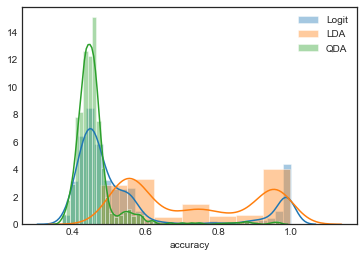

In [88]:
import seaborn as sns
sns.set_style('white')

param_models = ['Logit', 'LDA', 'QDA']

for model_name in param_models:
    sns.distplot(grouped_by_model.accuracy.get_group(model_name), label=model_name)

plt.legend()

Observations

- There are some interesting peaks here -- the distributions look bimodal.
- Both Logit and QDA models are highly concentrated in low accuracy, but LDA is more spread out

*TO DO: Try to find similarities in predictors/transformations for the instances clustered around these two modes*

###### KNN models

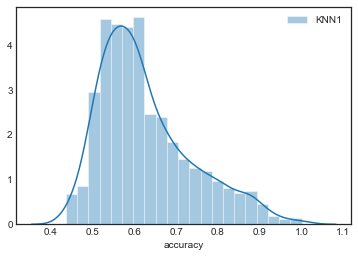

In [89]:
sns.distplot(grouped_by_model.accuracy.get_group('KNN1'), label='KNN1')

plt.legend()

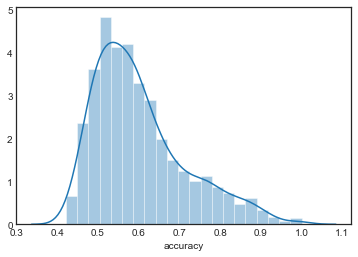

In [90]:
sns.distplot(grouped_by_model.accuracy.get_group('KNN2'), label='KNN2')

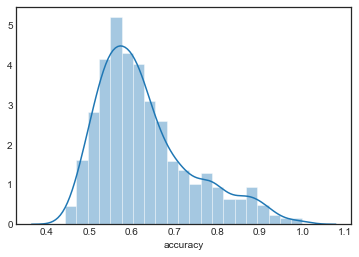

In [91]:
sns.distplot(grouped_by_model.accuracy.get_group('KNN3'), label='KNN3')

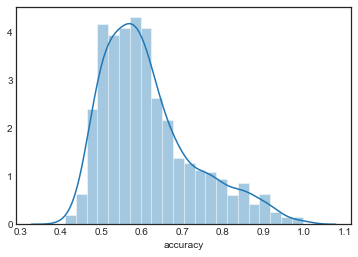

In [92]:
sns.distplot(grouped_by_model.accuracy.get_group('KNN4'), label='KNN4')

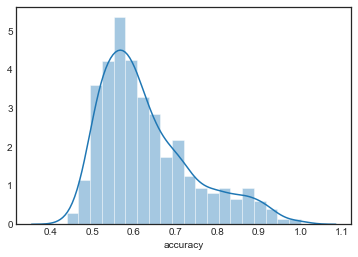

In [93]:
sns.distplot(grouped_by_model.accuracy.get_group('KNN5'), label='KNN5')

The distributions are all very similar, although they appear to become more concentrated as $N$ increases. 